# Kinetic analysis of strategy enabling anaerobic production of PHB

In this script, we have performed the ECM analyses for the thermodynamic investigation of the NOG+EMP pathway, also demonstrating how the analysis of other pathways and metabolic engineering strategies could be analyzed by other researchers with the custom-made functions we have developed in this study.

In [11]:
#from equilibrator_api import Q_ #for creating quantity variables
#import equilibrator_custom_functions as eq #custom functions created during analysis
#import numpy as np #numerical package
#import math
#import matplotlib.pyplot as plt #plotting package
#import custom_plot_functions as cpf

from equilibrator_api import Q_ #for creating quantity variables
import equilibrator_custom_functions as eq #custom functions created during analysis
import numpy as np #numerical package
import math
import matplotlib.pyplot as plt #plotting package
import matplotlib.ticker as mtick

In [12]:
#Setting physiological conditions as a Python dictionary
cellular_conditions = {
            "p_h": str(Q_("7.4")),
            "p_mg": str(Q_(3)),
            "ionic_strength": str(Q_('250 mM')),
            "temperature": str(Q_(30+273.15,"K")),
            "kcat_source": "fwd",
}

#Generating Compound Settings with the default eQuilibrator bounds
cs_default_bounds = eq.obtain_compound_settings("metabolite_reference_table_default", custom_bounds = True)
import warnings
warnings.filterwarnings('ignore')

In [13]:
Volume_per_CDW = Q_(1.9, 'ul/mg').to('L/g')
Y_ATP = Q_(1,'mol/mol') #mol ATP/mol pathway net reaction
maintenance = 0.81 #value in mmol_ATP/gCDW/h
mATP_perCDW = Q_((maintenance/1000/0.0019/3600)*3600*1.9e-3,'mol/gram/hour')
flux_ATP = mATP_perCDW/Y_ATP/Volume_per_CDW
absolute_flux = flux_ATP.to('M/s')
print(flux_ATP)

0.42631578947368426 mole / hour / liter


In [14]:
import warnings
# Filter out the specific warning
warnings.filterwarnings("ignore", message="In a future version, passing float-dtype values containing NaN and an integer dtype will raise IntCastingNaNError")

#In case we want to analyze also the PHB polymerization reaction
model_1mM = eq.ECM_analysis("CO_to_PHB_ECM",cs_default_bounds,cellular_conditions,absolute_flux)
lnC_ECM_1mM = model_1mM.ecf.optimize_ecm()[1]

# To exclude the PHB polymerization reaction from the ECM calculation
#import pandas as pd
# Read the original CSV file
#original_df = pd.read_csv("CO_to_PHB_ECM.csv")
# Exclude the last row
#modified_df = original_df.iloc[:-1]
# Save the modified DataFrame to a new CSV file
#modified_df.to_csv("CO_to_PHB_ECM_modified.csv", index=False)
#model_1mM = eq.ECM_analysis("CO_to_PHB_ECM_modified",cs_default_bounds,cellular_conditions,absolute_flux)
#lnC_ECM_1mM = model_1mM.ecf.optimize_ecm()[1]

## Total enzyme mass concentration

With the resulting log-concentration vector, total enzyme mass concentration can be determined with the function __eq.total_enzyme_volume__ (with inputs of model object and log-concentration vector). The result in gram/liter was also normalized to cell dry weight by dividing it with the volume per CDW value.

In [15]:
print((eq.total_enzyme_volume(model_1mM,lnC_ECM_1mM)*Volume_per_CDW,eq.total_enzyme_volume(model_1mM,lnC_ECM_1mM)))

(<Quantity(0.0757707555, 'dimensionless')>, <Quantity(39.879345, 'gram / liter')>)


## Molar concentrations of enzymes

Molar concentrations of each enzymes can be obtained in the followig manner:

In [16]:
enz_conc = dict(zip(model_1mM.reaction_ids,list( np.exp( model_1mM.ecf.ECF(lnC_ECM_1mM).value))))
print(enz_conc)
import csv
with open('protein_molar_concentrations.csv', 'w', newline='') as csv_file:  
    writer = csv.writer(csv_file,delimiter=',')
    for key, value in enz_conc.items():
      writer.writerow([key, value])

{'CODH_pump': 0.00011077573903344349, 'Hydrogenase': 3.523641145102776e-05, 'R5PK': 2.0070621483312654e-05, 'RiBPK': 1.872052048392453e-05, 'RiBPiso': 1.5513518080241917e-05, 'RbuCO': 1.6143641995141545e-05, 'PGK': 0.00013487085252331728, 'GAPDH': 3.9977334834095136e-05, 'TPI': 1.869051101662374e-05, 'FBPald': 2.092921517906888e-05, 'ADPPFK': 5.439530506484809e-05, 'TALA': 1.6886024588210534e-05, 'Tkt': 1.1963688679348505e-05, 'RibI': 1.571630341178717e-05, 'RibE': 1.7115078843703127e-05, 'PKT': 7.303867971487338e-06, 'PTA': 5.164336832346592e-05, 'Thio': 5.0062223955656947e-05, 'AAR': 7.1273908426537715e-06, 'PHBsyn': 1.0297030090344067e-05}


## Mass concentrations of enzymes

With the __enzyme_cost_distribution__ function, we can obtain an ordered dictionary of individual enzyme mass concentrations (in grams/liter) and individual percentages of total enzyme mass concentration.

In [17]:
(totals_1mM,percents_1mM) = eq.enzyme_cost_distribution(model_1mM,lnC_ECM_1mM)
import csv
with open('protein_mass_concentrations.csv', 'w', newline='') as csv_file:  
    writer = csv.writer(csv_file,delimiter=',')
    for key, value in totals_1mM.items():
      writer.writerow([key, value])

## Metabolite concentrations

Metabolite concentrations (in M) can be verified in the following manner:

In [18]:
conc_dict_1mM = dict(zip(model_1mM.compound_ids, np.exp(lnC_ECM_1mM).flatten()))
print(conc_dict_1mM)
#Example of how to access specific value:
#conc_dict_1mM['NADH']

{'H2O': 0.9999999999958988, 'ATP': 0.002790000001472504, 'ADP': 0.0003186110283945659, 'NAD': 0.0003103448050831309, 'Pi': 0.0008421578093054739, 'NADH': 0.00034286178229471465, 'CoA': 3.0887389497327414e-05, 'CO2': 5.000000002464001e-06, 'AMP': 0.0019999999996686744, 'AcCoA': 0.0020000000002260935, 'G3P': 0.0007066813485114662, 'DHAP': 0.0010775440820839576, 'PRibPP': 5.221571129204091e-06, 'Ri5P': 5.000000031203083e-06, 'P3G': 0.0020000000001748333, 'AACoA': 5.000000002498826e-06, 'Ru5P': 5.000000184148574e-06, 'X5P': 4.9137563025334085e-05, 'H2': 5.0000000024870755e-06, 'E4P': 0.0019999999840321922, 'BPG': 5.000000002703676e-06, 'S7P': 5.000000086383371e-06, 'AcP': 0.002000000000271938, 'FBP': 0.001999999999658645, 'HB': 0.001999999993027782, 'HBCoA': 0.0007844894538802207, 'RuBP': 8.906988563907785e-05, 'PHB': 5.0000000169319036e-06, 'CO': 0.0010000000001654306, 'F6P': 5.000000004081285e-06, 'RiBP': 9.460914157243875e-06}


## Plotting enzyme demand distribution:

We use the function __eq.ECM_plot__ for plotting these graphs. The main difference from the original eQuilibrator plotting function is that in our case the measured concentrations of metabolites are not mandatory for plotting the graph.

Text(0, 0.5, '')

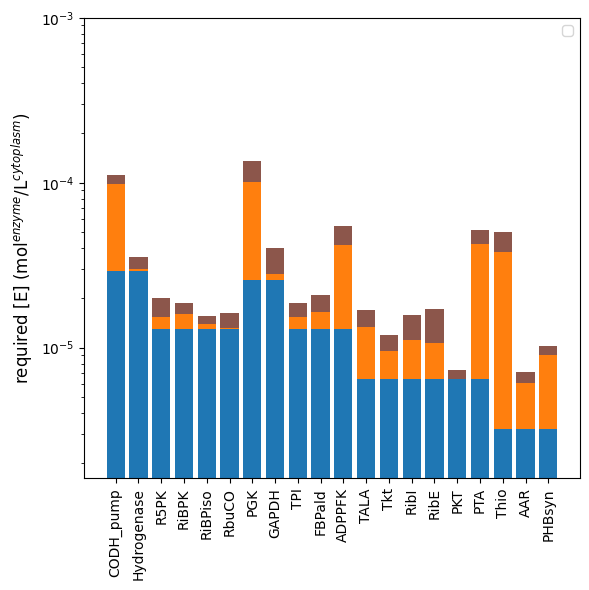

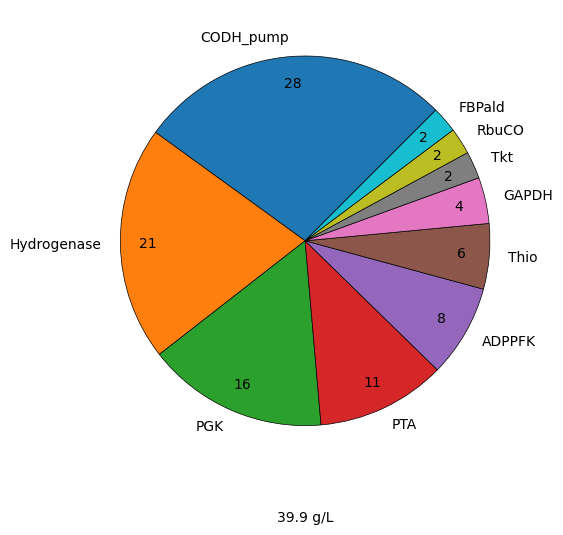

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the first plot and saved figure (subplot 1 content)
fig1, ax1 = plt.subplots(figsize=(6, 6))  # Increase figure size
ECM_1mM_mass_conc = round(eq.total_enzyme_volume(model_1mM, lnC_ECM_1mM).m_as('g/L'), 2)
ax1.set_ylim((pow(10, -7), pow(10, -3)))
eq.ECM_plot(model_1mM, lnC_ECM_1mM, ax1)

ax1.legend('')
ax1.set_ylabel('required [E] (mol$^{enzyme}$/L$^{cytoplasm}$)')

# Adjust axis label font size if necessary
# ax1.set_xlabel('X-axis label', fontsize=12)
# ax1.set_ylabel('Y-axis label', fontsize=12)

plt.tight_layout()  # Adjust subplot layout to avoid cutting off axis labels

# Save the first figure
#fig1.savefig('ECM_molar_histogram.tiff', dpi=150)

# Create the second plot and saved figure (subplot 2 content)
fig2, ax2 = plt.subplots(figsize=(9, 6))  # Single plot

# Assuming 'protein_mass_concentrations.csv' contains two columns without headers
df = pd.read_csv('protein_mass_concentrations.csv', header=None, names=['Proteins', 'Concentrations'])
# Filter data based on the threshold (e.g., 2%)
cut_off = 2
threshold = (cut_off/100) * df['Concentrations'].sum()
filtered_data = df[df['Concentrations'] > threshold]
labels = filtered_data['Proteins']
sizes = filtered_data['Concentrations']

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.0f', startangle=45, pctdistance=0.85, 
                                          labeldistance=1.1, wedgeprops=dict(edgecolor='black', linewidth=0.5))

ECM_1mM_mass_conc = round(eq.total_enzyme_volume(model_1mM, lnC_ECM_1mM).m_as('g/L'), 1)
ax2.text(0.5, -0.1, str(ECM_1mM_mass_conc) + ' g/L', ha='center', va='center', transform=ax2.transAxes)

ax2.set_ylabel('')
#fig2.savefig('ECM_mass_pie.tiff', dpi=150)

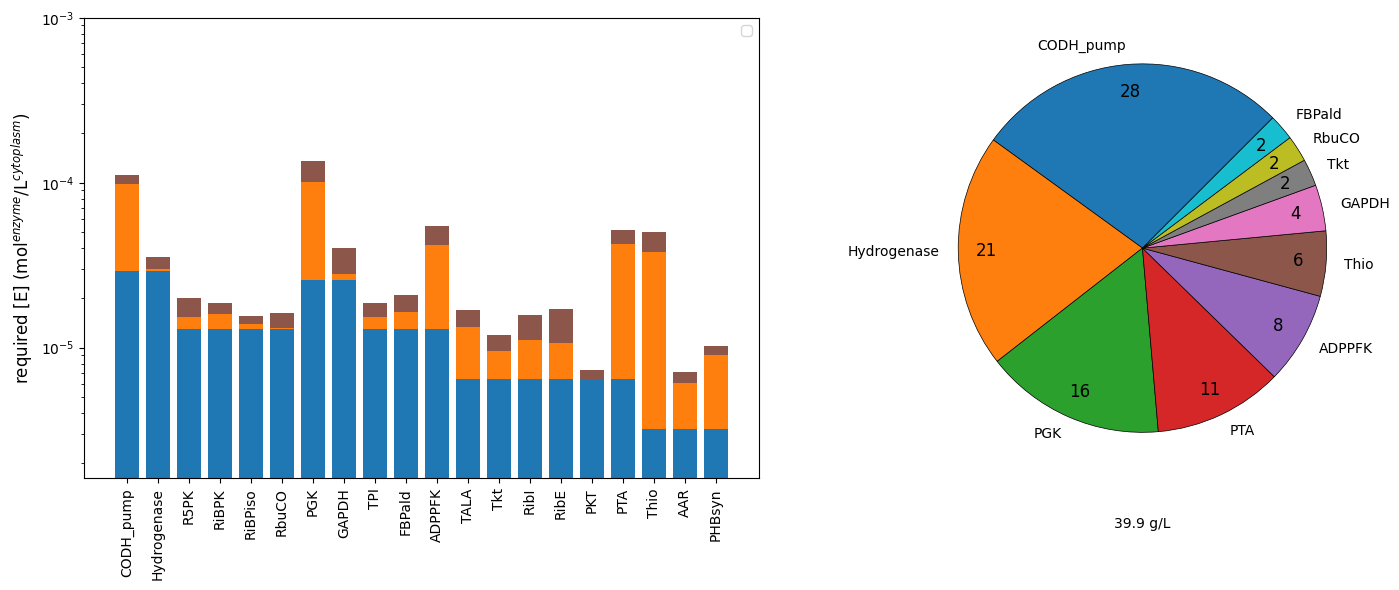

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Create a single figure with two subplots

# Plotting subplot 1
ECM_1mM_mass_conc = round(eq.total_enzyme_volume(model_1mM, lnC_ECM_1mM).m_as('g/L'), 2)
ax1.set_ylim((pow(10, -7), pow(10, -3)))
eq.ECM_plot(model_1mM, lnC_ECM_1mM, ax1)

ax1.legend('')
ax1.set_ylabel('required [E] (mol$^{enzyme}$/L$^{cytoplasm}$)')

# Plotting subplot 2
# Assuming 'protein_mass_concentrations.csv' contains two columns without headers
df = pd.read_csv('protein_mass_concentrations.csv', header=None, names=['Proteins', 'Concentrations'])
# Filter data based on the threshold (e.g., 2%)
cut_off = 2
threshold = (cut_off/100) * df['Concentrations'].sum()
filtered_data = df[df['Concentrations'] > threshold]
labels = filtered_data['Proteins']
sizes = filtered_data['Concentrations']

# Plot pie chart with custom label distance
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.0f', startangle=45, pctdistance=0.85, 
                                   labeldistance=1.1, wedgeprops=dict(edgecolor='black', linewidth=0.5))

# Adjust the positions of individual labels outside the pie chart
for autotext in autotexts:
    autotext.set_fontsize(12)  # Adjust font size of the labels
    autotext.set_horizontalalignment('center')  # Center the labels

ECM_1mM_mass_conc = round(eq.total_enzyme_volume(model_1mM, lnC_ECM_1mM).m_as('g/L'), 1)
ax2.text(0.5, -0.1, str(ECM_1mM_mass_conc) + ' g/L', ha='center', va='center', transform=ax2.transAxes)

ax2.set_ylabel('')

# Save the figure
plt.tight_layout()  # Adjust subplot layout to avoid cutting off axis labels
fig.savefig('combined_figure_with_custom_label_positions.tiff', dpi=150)

